In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
import astropy
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import illustris_python as il
from astropy.cosmology import FlatLambdaCDM

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089, Ob0=0.0486, Tcmb0=2.725)

### redshift_to_snap(redshift)
Simple function which converts a redshift into the corresponing snapshot name to easily construct the path to the halo

**Parameters**:
- **redshift**: Redshift you want to convert (has to be 6,8 or 10)

**Returns**:
- **snapname**: Name of the snapshot the **redshift** corresponds to

In [3]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

In [4]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [5]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    rel_dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length

    dist_lum_df = pd.DataFrame({'dist':rel_dist,'lum':lum[3]})
    
    return dist_lum_df

In [109]:
def r_fesc(df, mass_min, mass_max, conf, with_emitted=False):
    sub_df = df[(np.log10(df['StarMass'])>=mass_min) & (np.log10(df['StarMass'])<=mass_max)]
    age_all = []
    dist_all = []
    fesc_all = []
    n_ion_all = []
    for index, row in sub_df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        dist = dist_lum_df['dist']
        escaped = df['escaped_photons'][index].sum(axis=0)
        emitted = df['emitted_photons'][index].sum(axis=0) 
        fesc = df['per_source'][index]
        if with_emitted:
            n_ion=emitted
        else:
            n_ion = escaped
        age = df['StellarAges'][index]
        
        dist_all.extend(dist)
        fesc_all.extend(fesc)
        n_ion_all.extend(n_ion)
        age_all.extend(age)
    
    dist_all = np.array(dist_all)
    fesc_all = np.array(fesc_all)
    n_ion_all = np.array(n_ion_all)
    age_all = np.array(age_all)
    return (dist_all, fesc_all, n_ion_all, age_all)

### place_fesc(df)
Helper function that calculates the fraction of halos with an escape fraction below the threshold and sets these values to a small values above this threshold

**Parameters**:
- **fesc_arr**: Array of escape fractions
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)

**Returns**:
- **frac_small**: Fraction of halos with an escape fraction below **threshold**
- **fesc_arr**: Same as the input array with all values below **threshold** replaced by $f_\mathrm{esc} = 1.5 \cdot \mathrm{threshold}+\mathcal{U}(-0.5\cdot \mathrm{threshold},0.5\cdot \mathrm{threshold})$

In [7]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

### get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3)
Return means, error and variance of the escape fraction of each bin, the fraction of halos with small escape fraction for each bin as well as the centers of the bin for a dataframe

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)



**Returns**:
- **x_values**: Masses (star or halo) of the individual halos
- **fesc**: f_esc of all halos
- **centers**: Centers of the logarithmically spaced bins
- **means**: Array of the average f_esc values
- **quantile16**: Values of the 16% quantile
- **quantile84**: Values of the 84% quantile
- **error**: Uncertainties in the average f_esc values
- **variance**: Variance in f_esc in a given bin
- **frac_small_arr**: Fraction of halos with f_esc below **threshold** in each bin 

In [8]:
def get_scatter(df_fesc, mode='r', bins=30, log=False, lim=1.):
    
    if mode=='r':
        quant = 'dist'
    elif mode=='age':
        quant = 'age'
    elif mode=='n_ion':
        quant = 'dist'
        norm = df_fesc[df_fesc['dist']<lim]['n_ion'].sum()
    elif mode == 'a_r':
        quant = 'dist'
    elif mode == 'n_ion_a':
        quant = 'age'
        norm = df_fesc[df_fesc['dist']<lim]['n_ion'].sum()
    
    x_values = df_fesc[quant]
    if log:
        edges = np.logspace(np.log10(np.min(x_values)),np.log10(lim), bins)
        if mode == 'n_ion':
            raise NotImplementedError('The propper bin weighting for logarithmic density in the normalization is not implemented yet')
    else:
        edges = np.linspace(0,lim, bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    centers = []
    
    lower_quant_boundary = 0.16
    upper_quant_boundary = 0.84
    
    for i in range(len(edges)-1):
        filt = (edges[i]*(1-1e-10)<df_fesc[quant]) & (df_fesc[quant]<edges[i+1])
        centers.append((edges[i]+edges[i+1])/2)
        
        if ((mode=='r') or (mode=='age')):
            sub_fesc = df_fesc[filt]['fesc']
            means.append(sub_fesc.median())
            quantile16.append(sub_fesc.quantile(lower_quant_boundary))
            quantile84.append(sub_fesc.quantile(upper_quant_boundary))
        elif (mode=='a_r'):
            sub_ages = df_fesc[filt]['age']
            means.append(sub_ages.median())
            quantile16.append(sub_ages.quantile(lower_quant_boundary))
            quantile84.append(sub_ages.quantile(upper_quant_boundary))
        else:
            sub_n_ion = df_fesc[filt]['n_ion']
            sub_n_ion_sum = sub_n_ion.sum() 
            means.append(sub_n_ion_sum/norm)
            quantile16.append(None)
            quantile84.append(None)

    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84 = np.array(quantile84)
    centers = np.array(centers)
        
    return centers, means, quantile16, quantile84

In [9]:
def star_ages(ID, redshift, conf, star_df):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    star_ID_names = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[4])
    star_IDs = star_ID_names[4].apply(lambda element: int(element[1:-5]))

    a_formation = star_df.loc[star_IDs]['formation']
    z_formation = scale_to_red(a_formation)
    ages = (cosmo.age(redshift).value-cosmo.age(z_formation).value+0.005)*1000
    return ages

In [124]:
def plot_med_fesc_dep(df, mass_min_arr, mass_max_arr, mode='r', conf='fid2', labels=None, 
                      colors=['r','g','b'], bins=30, threshold=1e-3, save=False):
    
    labelsize = 50
    legendsize = 35
    ticksize = 35
    plt_linewidth  = 6
    ax_linewidth = 3
    fig_width = 20
    fig_height = 25
    y_lim_low = threshold
    legend_pos = 'lower right'

    if mode == 'r':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$\langle f_\mathrm{esc} \rangle$'
    elif mode=='age':
        x_label = r'$a_\mathrm{star}$[Myr]'
        y_label = r'$\langle f_\mathrm{esc} \rangle$'
    elif mode == 'n_ion':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$N_\mathrm{ion}/N_\mathrm{ion, tot}$'
    elif mode == 'a_r':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$a_\mathrm{star}$[Myr]'
    elif mode == 'n_ion_a':
        x_label = r'$a_\mathrm{star}$[Myr]'
        y_label = r'$N_\mathrm{ion}/N_\mathrm{ion, tot}$'
    else:
        raise NotImplementedError(f'The mode {mode} is not implemented yet.')
    
    if len(mass_min_arr) != len(mass_max_arr):
        raise ValueError(f'Len of mass_min_arr has to be equal to len of mass_max_arr receiven {len(mass_min_arr)} and {len(mass_max_arr)} instead')
    if labels == None:
        labels = [i for i in range(len(mass_min_arr))]
    
    ax1 = plt.subplot2grid((4,1), (0,0), rowspan=2)
    max_values = np.zeros(len(mass_min_arr))
    for i in range(len(mass_min_arr)):
        centers, means = plot_fesc_dep(df, mass_min_arr[i], mass_max_arr[i], mode=mode, 
                                       conf=conf, bins=bins, return_result=True)
        max_values[i] = means.max()
        ax1.plot(centers, means, linewidth=plt_linewidth, label=labels[i], color=colors[i])
    if (mode=='n_ion') or (mode=='n_ion_a'):
        for i in range(len(mass_min_arr)):
            centers, means = plot_fesc_dep(df, mass_min_arr[i], mass_max_arr[i], mode=mode, 
                                           conf=conf, bins=bins, return_result=True, with_emitted=True)
            max_values[i] = means.max()
            ax1.plot(centers, means, linewidth=plt_linewidth, linestyle='dashed', color=colors[i])
    y_lim_high = 1.1*max_values.max()
    
    if mode=='age':
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    if mode=='n_ion_a':
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    elif mode=='r':
        ax1.set_yscale('log')
    ax1.set_ylim(y_lim_low, y_lim_high)
    #ax1.set_xlim(x_lim_low, x_lim_high)
    
    ax1.set_ylabel(y_label, size=labelsize)
    ax1.set_xlabel(x_label, size=labelsize)

    xticklabels = ax1.get_xticklabels()
    plt.legend(fontsize=legendsize, loc=legend_pos)
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    plt.rc('axes', linewidth=ax_linewidth)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    if save:
        path = f'/u/ivkos/analysis/plots/fesc_{mode}_variations.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show()
    return

In [110]:
def plot_fesc_dep(df, mass_min, mass_max, mode='r', conf='fid2', bins=30, 
                  threshold=1e-3, save = False, return_result=False, with_emitted=False):        
    
    labelsize = 50
    legendsize = 40
    ticksize = 35
    plt_linewidth  = 6
    ax_linewidth = 3
    fig_width = 20
    fig_height = 25
    y_lim_low = threshold
    y_label = '$f_\mathrm{esc}$'
    legend_pos = 'lower right'
    
    dist, fesc, n_ion, age = r_fesc(df, mass_min, mass_max, conf=conf, with_emitted=with_emitted)
    fesc_df = pd.DataFrame({'dist':dist,'fesc':fesc, 'n_ion':n_ion, 'age':age})
    if mode=='r':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = fesc_df['fesc'].max()*1.1
        log=False
    elif mode=='n_ion':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = 0.15
        log=False
    elif mode=='age':
        x_label = r'$a_\mathrm{star}$[Myr]'
        x_lim_low = fesc_df['age'].min()
        x_lim_high = fesc_df['age'].max()
        y_lim_high = fesc_df['fesc'].max()*1.1
        x_quant=age
        log=True
    elif mode == 'a_r':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = 1.
        log=False
    elif mode == 'n_ion_a':
        x_label = r'$a_\mathrm{star}$[Myr]'
        x_quant=age
        x_lim_low = fesc_df['age'].min()
        x_lim_high = fesc_df['age'].max()
        y_lim_high = 0.15
        log=True
    else:
        raise NotImplementedError(f'The mode {mode} is not implemented yet.')
    
    centers, means, quantile16, quantile84 = get_scatter(fesc_df, mode=mode, bins=bins, log=log, lim=x_lim_high)
    
    if return_result:
        return (centers, means)
    _, fesc_plot = place_fesc(fesc, threshold)
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((4,1), (0,0), rowspan=2)
    ax1.scatter(x_quant, fesc_plot)
    ax1.set_yscale('log')
    if mode=='age':
        ax1.set_xscale('log')
    ax1.set_ylim(y_lim_low, y_lim_high)
    ax1.set_xlim(x_lim_low, x_lim_high)
    ax1.plot(centers, means, linewidth=plt_linewidth,  color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
    ax1.fill_between(centers, quantile16, quantile84, color='red', alpha=0.3)
    ax1.set_ylabel(y_label, size=labelsize)
    ax1.set_xlabel(x_label, size=labelsize)

    xticklabels = ax1.get_xticklabels()
    plt.legend(fontsize=legendsize, loc=legend_pos)
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    plt.rc('axes', linewidth=ax_linewidth)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    if save:
        path = f'/u/ivkos/analysis/plots/fesc_r.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    return

In [12]:
def add_age(df, conf, star_dic):
    ages = []
    for index, row in df.iterrows():
        age = star_ages(ID=row.ID, redshift=row.z, conf=conf, star_df=star_dic[row.z])
        ages.append(age)
    df['StellarAges'] = pd.Series(ages)
    return

In [35]:
def update_df(name, sim_conf, new_df_name, star_dic):
    df = pd.read_pickle(name)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    add_age(df, sim_conf, star_dic)
    df.to_pickle(new_df_name)
    return

In [31]:
star_dic = build_star_dic()

In [36]:
df=pd.read_pickle('df_no_dust.pickle')
update_df('df_no_dust.pickle', 'fid2', new_df_name='df_no_dust_ages.pickle', star_dic=star_dic)

In [106]:
df=pd.read_pickle('df_no_dust_ages.pickle')

In [ ]:
df

In [15]:
def scale_to_red(a):
    return 1/a-1

In [16]:
basePath = '/virgo/simulations/IllustrisTNG/L35n2160TNG/output'
h = 0.6774

In [17]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]
def redshift_to_snap_num(redshift):
    snapnumbers = {6:13, 8:8, 10:4}
    return snapnumbers[redshift]

In [18]:
conf='fid2'
redshift = 10
ID=4276
snap=redshift_to_snap(redshift)
snap_num=redshift_to_snap_num(redshift)

In [19]:
def source_pos(ID, redshift, conf, side_length):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    
    coord = np.array(coord)
    lum = np.vectorize(lum_str_to_float)(lum)
    
    halo_cube = np.zeros((side_length,  side_length, side_length))
    for i in range(coord.shape[0]):
        pos = coord[i,:]
        halo_cube[pos[0],pos[1],pos[2]]+=lum[i][0]*1e52
    return halo_cube

In [24]:
mass_min_arr = [6.0, 6.5, 7.0, 7.5, 8.0, 8.5]
mass_max_arr = [6.1, 6.6, 7.1, 7.6, 8.1, 8.6]

In [141]:
mass_min_arr2 = [6.0, 7.0, 8.0]
mass_max_arr2 = [6.5, 7.5, 8.5]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = [r'$\log(M_\mathrm{Star})=6.0-6.5$',r'$\log(M_\mathrm{Star})=7.0-7.5$',r'$\log(M_\mathrm{Star})=8.0-8.5$']

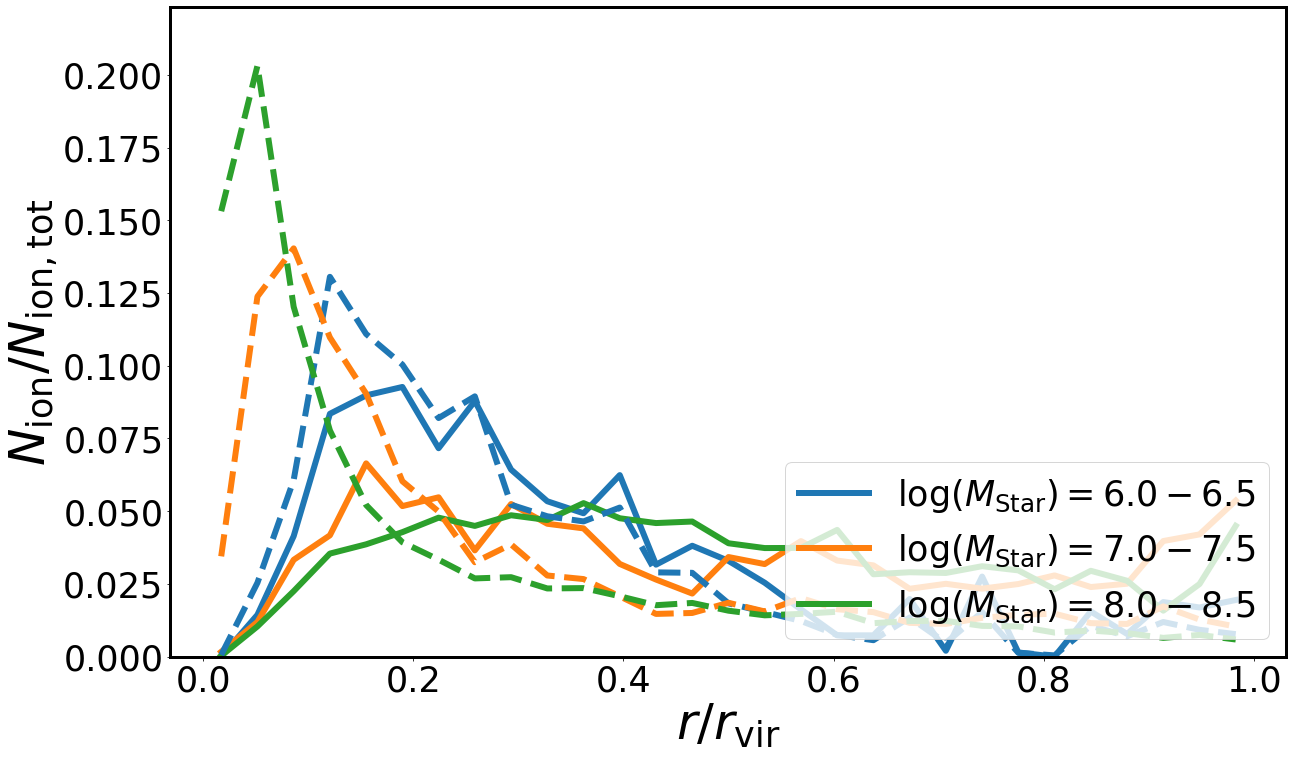

In [143]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='n_ion', conf='fid2', labels=labels, 
                  colors=colors, bins=30, threshold=0, save=True)

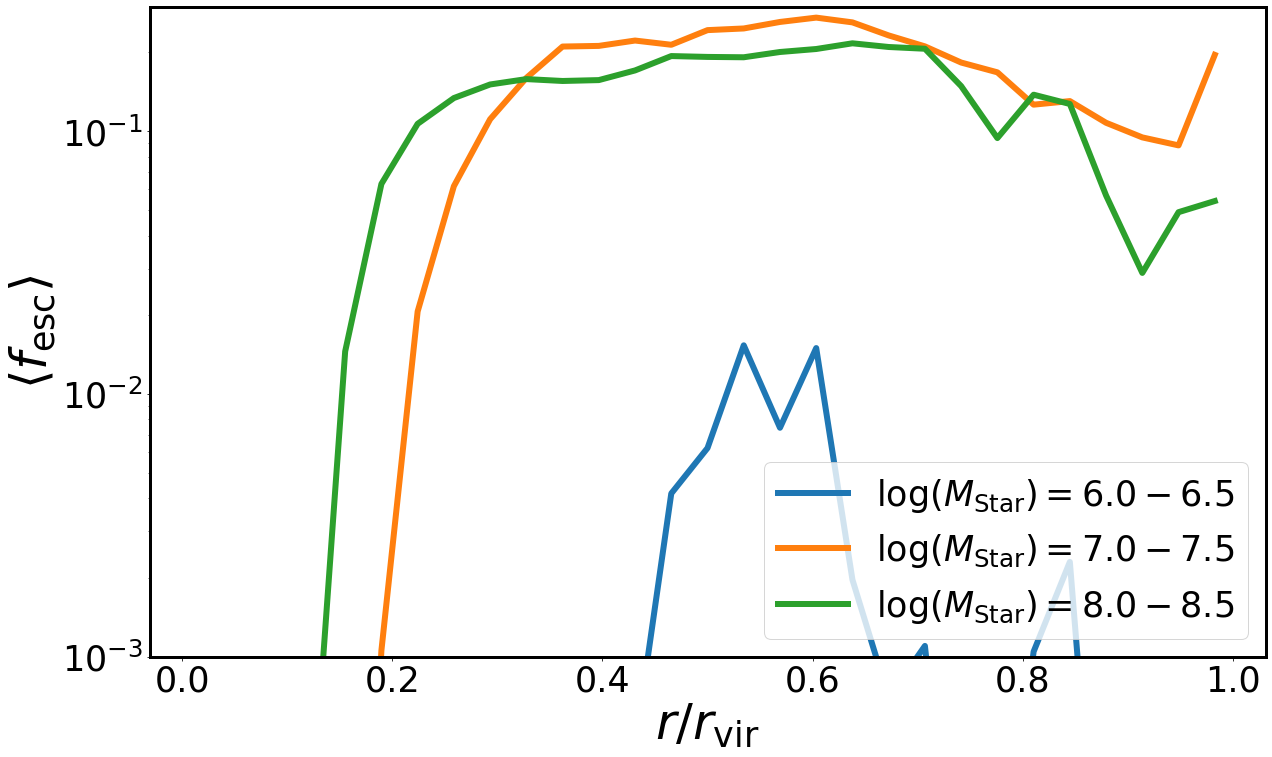

In [285]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='r', conf='fid2', labels=labels, bins=30, threshold=1e-3, save=True)

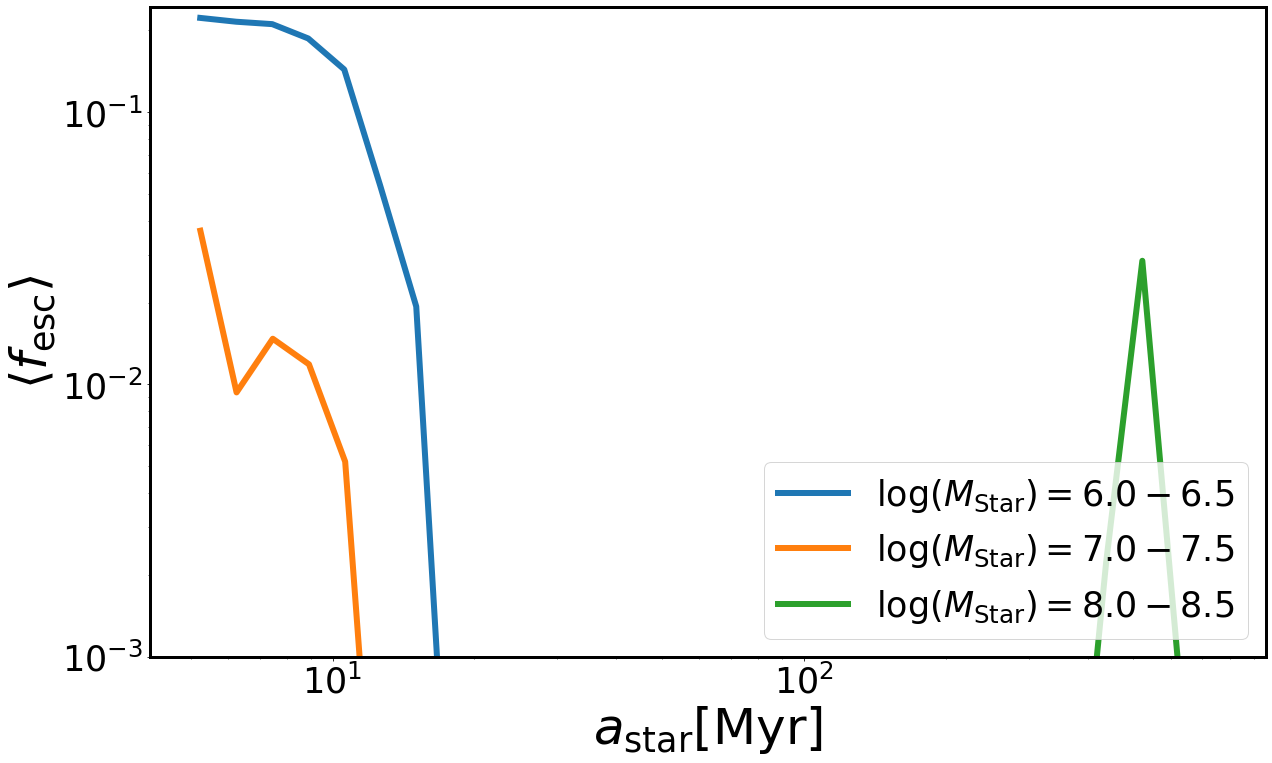

In [286]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='age', conf='fid2', labels=labels, bins=30, threshold=1e-3, save=True)

6.0
14951
14951
14951
14951
********************************************************************************
7.0
137603
137603
137603
137603
********************************************************************************
8.0
693925
693925
693925
693925
********************************************************************************
6.0
14951
14951
14951
14951
********************************************************************************
7.0
137603
137603
137603
137603
********************************************************************************
8.0
693925
693925
693925
693925
********************************************************************************


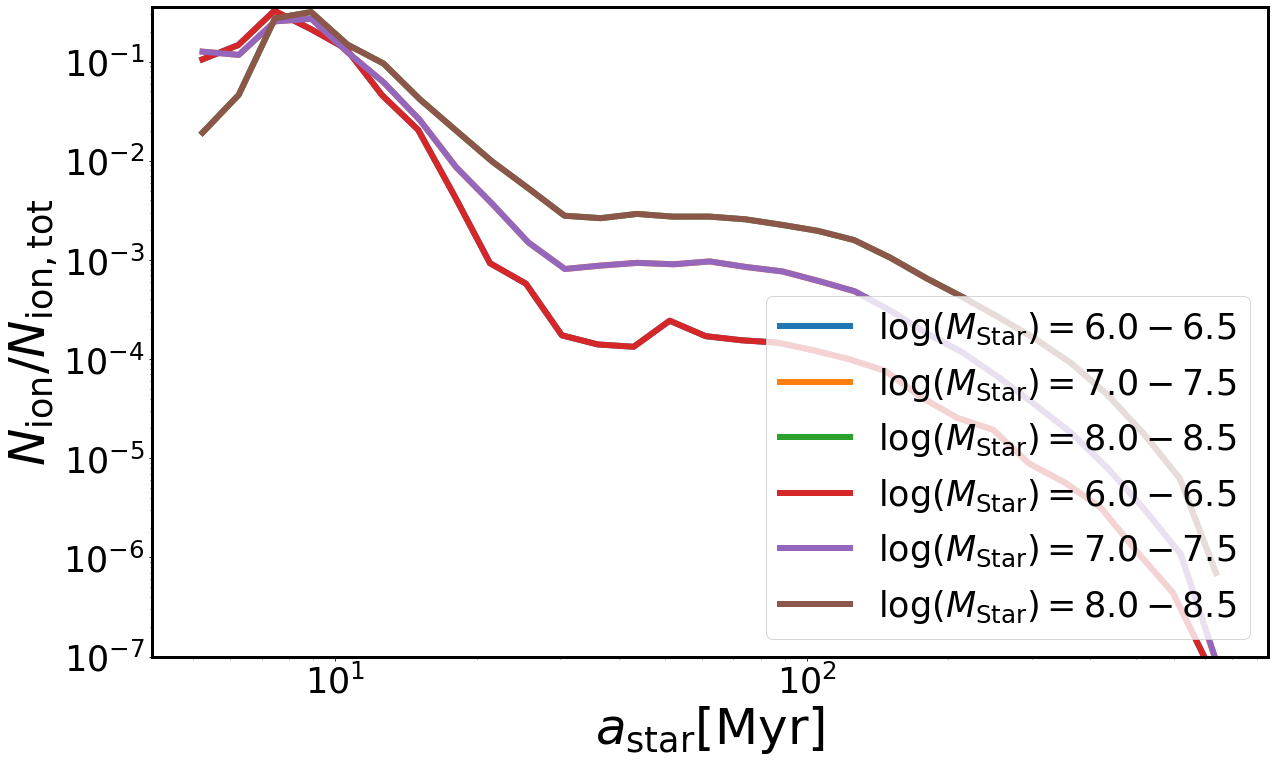

In [108]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='n_ion_a', conf='fid2', 
                  labels=labels, bins=30, threshold=1e-7, save=False)

In [30]:
def build_star_dic():
    stars_6 = il.snapshot.loadSubset(basePath, 13, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    stars_8 = il.snapshot.loadSubset(basePath, 8, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    stars_10 = il.snapshot.loadSubset(basePath, 4, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    
    stars_6_df = pd.DataFrame({'formation':stars_6['GFM_StellarFormationTime']}, index=stars_6['ParticleIDs'])
    stars_8_df = pd.DataFrame({'formation':stars_8['GFM_StellarFormationTime']}, index=stars_8['ParticleIDs'])
    stars_10_df = pd.DataFrame({'formation':stars_10['GFM_StellarFormationTime']}, index=stars_10['ParticleIDs'])
    
    stars_6_df.sort_index(inplace=True)
    stars_8_df.sort_index(inplace=True)
    stars_10_df.sort_index(inplace=True)
    
    star_dic = {6:stars_6_df, 8:stars_8_df, 10:stars_10_df}
    return star_dic

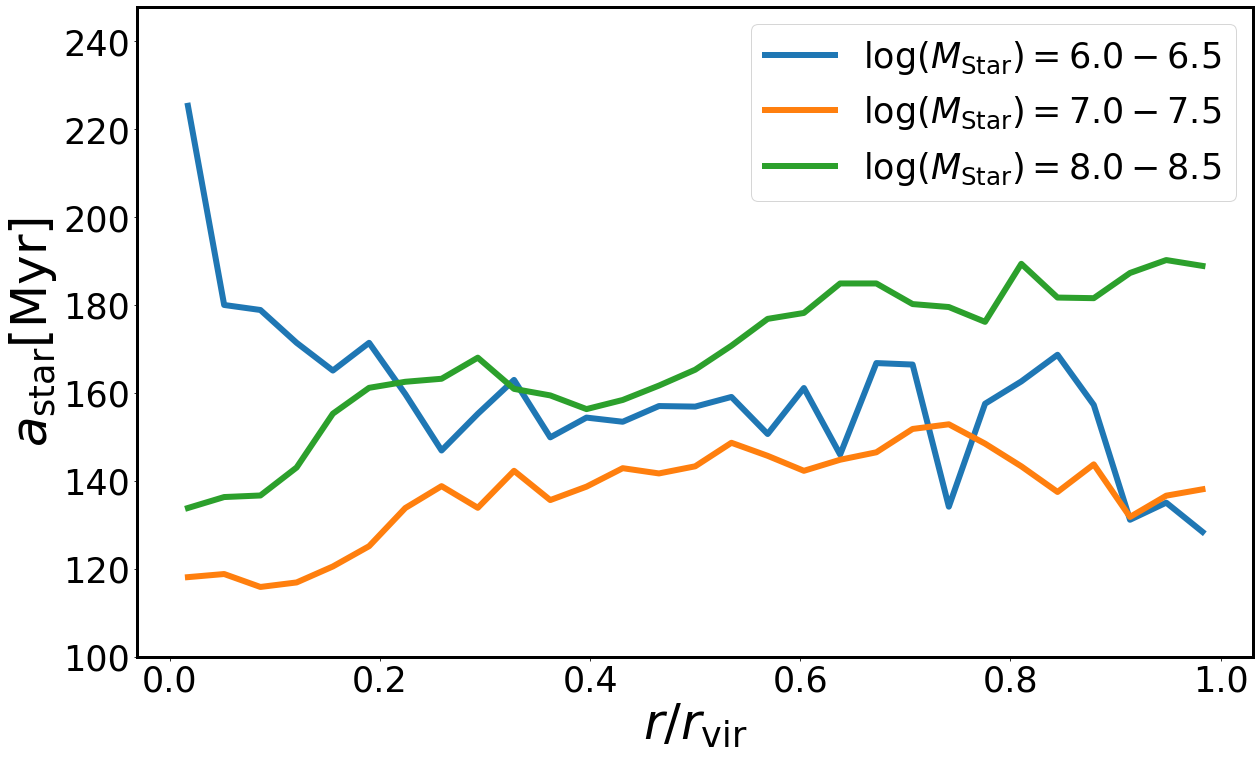

In [272]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='a_r', conf='fid2', labels=labels, bins=30, threshold=100, save=True)